**This kernel is follow up of post on analytics vidhya  [Link](https://www.analyticsvidhya.com/blog/2018/03/essentials-of-deep-learning-visualizing-convolutional-neural-networks/)**

## Preliminary Methods
### Plotting model architecture

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.misc import imread
from sklearn.metrics import accuracy_score

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from keras.models import Sequential , Model
from keras.layers import Input, Dense , Flatten , Dropout ,Activation , Conv2D , MaxPooling2D
import keras 
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['train.csv', 'sample_submission.csv', 'test.csv']


In [2]:
rn = np.random.RandomState(128)

In [3]:
directory = "../input"

### loading data 

In [4]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [5]:
train_y = keras.utils.np_utils.to_categorical(train.label.values)
train.drop('label', axis=1 , inplace=True)

In [6]:
image_data = train.values
train_x = np.array([image_data[i].reshape(28,28,1) for i in range(image_data.shape[0])])
test_image = test.values
test_x = np.array([test_image[i].reshape(28,28,1) for i in range(test_image.shape[0])])

In [7]:
print(train_y.shape)
print(train_x.shape)

(42000, 10)
(42000, 28, 28, 1)


## Preprocessing Data

In [8]:
# Normalising images

train_x = train_x/255.0
test_x = test_x/255.0
#train_y = pd.get_dummies(train_y)

## Splitting dataset



In [9]:
split = int(train_x.shape[0]*0.8)

In [10]:
train_x, val_x = train_x[:split], train_x[split:]
train_y, val_y = train_y[:split], train_y[split:]

# Creating Model

In [11]:
epochs =5 
batch_size = 128

model = Sequential()
model.add(Conv2D(32 , kernel_size=(3,3) , activation='relu' , input_shape=(28,28,1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', name='preds'))

In [12]:
model.compile(loss='categorical_crossentropy' , optimizer='adam', metrics=['accuracy'])
trained_model = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(val_x, val_y))
pred = model.predict_classes(test_x)

Train on 33600 samples, validate on 8400 samples
Epoch 1/5
33600/33600 [==============================] - 60s 2ms/step - loss: 0.3167 - acc: 0.9023 - val_loss: 0.0803 - val_acc: 0.9756
Epoch 2/5
33600/33600 [==============================] - 59s 2ms/step - loss: 0.1085 - acc: 0.9680 - val_loss: 0.0515 - val_acc: 0.9839
Epoch 3/5
33600/33600 [==============================] - 59s 2ms/step - loss: 0.0779 - acc: 0.9766 - val_loss: 0.0434 - val_acc: 0.9871
Epoch 4/5
33600/33600 [==============================] - 58s 2ms/step - loss: 0.0613 - acc: 0.9807 - val_loss: 0.0378 - val_acc: 0.9887
Epoch 5/5
33600/33600 [==============================] - 58s 2ms/step - loss: 0.0537 - acc: 0.9825 - val_loss: 0.0408 - val_acc: 0.9877


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [14]:
from keras.utils import plot_model
plot_model(model, to_file='model.jpg')

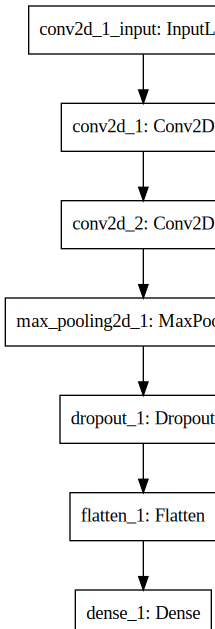

In [15]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Visualize filters

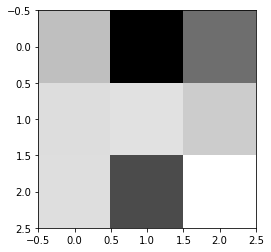

In [16]:
top_layer = model.layers[0]
import matplotlib.pyplot as plt
plt.imshow(top_layer.get_weights()[0][:, :, :, 0].squeeze(), cmap='gray')

## Activation Maps
### Maximal Activations

**Note: Before going to next part be sure to install keras-vis package. `!pip install keras-vis` would work** 


In [17]:
!pip uninstall keras-vis
!pip install git+https://github.com/raghakot/keras-vis.git -U

Skipping keras-vis as it is not installed.
  Cloning https://github.com/raghakot/keras-vis.git to /tmp/pip-req-build-zmq0gb64
  Running setup.py bdist_wheel for keras-vis ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-zdtd5qw3/wheels/c5/ae/e7/b34d1cb48b1898f606a5cce08ebc9521fa0588f37f1e590d9f
Successfully built keras-vis


In [18]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

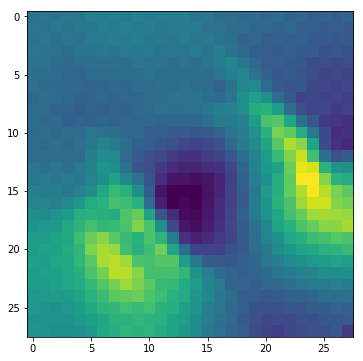

In [19]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name.
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'preds')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 0
img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
plt.imshow(img[..., 0])

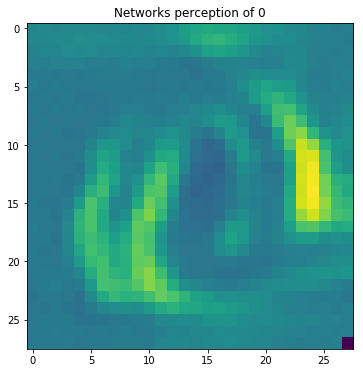

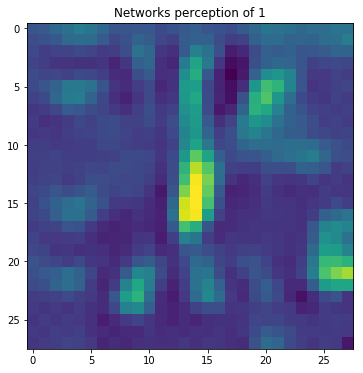

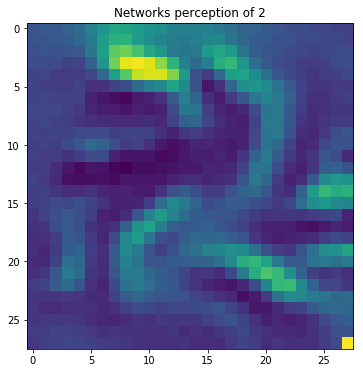

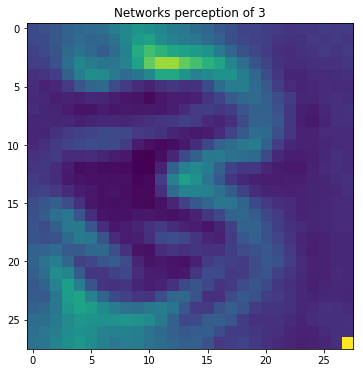

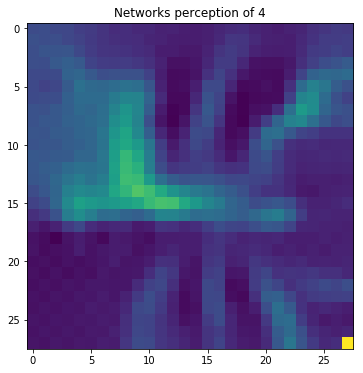

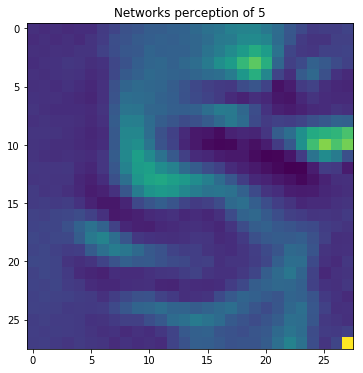

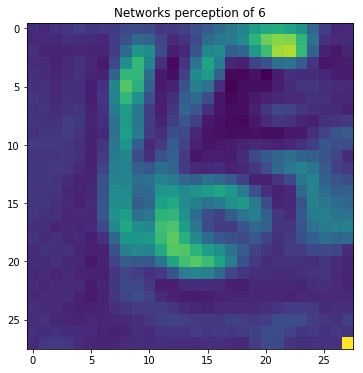

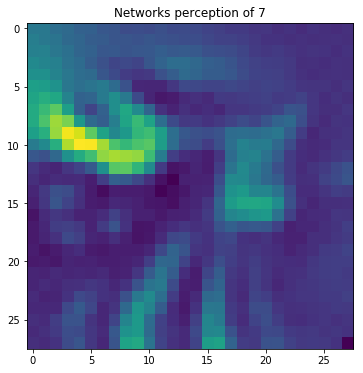

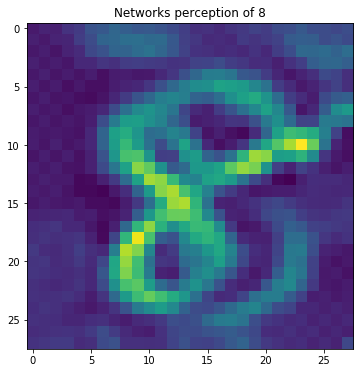

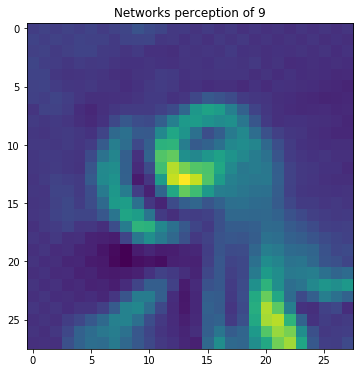

In [20]:
for output_idx in np.arange(10):
   # Lets turn off verbose output this time to avoid clutter and just see the output.
   img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
   plt.figure()
   plt.title('Networks perception of {}'.format(output_idx))
   plt.imshow(img[..., 0])

## Image Occlusion
In an image classification problem, a natural question is if the model is truly identifying the location of the object in the image, or just using the surrounding context. We took a brief look at this in gradient based methods above. Occlusion based methods attempt to answer this question by systematically occluding different portions of the input image with a grey square, and monitoring the output of the classifier. 

In [21]:
def iter_occlusion(image, size=8):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps

   occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
   occlusion_center = np.full((size, size, 1), [0.5], np.float32)
   occlusion_padding = size * 2

   # print('padding...')
   image_padded = np.pad(image, ((occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) ), 'constant', constant_values = 0.0)

   for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

       for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
           tmp = image_padded.copy()

           tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
             x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
             = occlusion

           tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

           yield x - occlusion_padding, y - occlusion_padding, \
             tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]





In [22]:
train_y[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

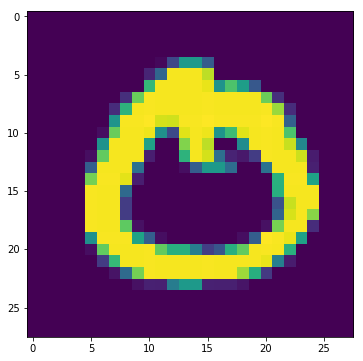

In [23]:
i = 23  # for example
data = train_x[i]
correct_class = np.argmax(train_y[4])

# input tensor for model.predict
inp = data.reshape(1, 28, 28, 1)

# image data for matplotlib's imshow
img = data.reshape(28, 28)

# occlusion
img_size = img.shape[0]
occlusion_size = 4

# preview
_ = plt.imshow(img)

In [24]:
print('occluding...')

heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):

    X = img_float.reshape(1, 28, 28, 1)
    out = model.predict(X)
    #print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    #print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1

occluding...


In [25]:
pred = model.predict(inp)
print('Correct class: {}'.format(correct_class))
print('Predicted class: {} (prob: {})'.format(np.argmax(pred), np.amax(out)))

print('Predictions:')
for class_id, count in counters.items():
    print('{}: {}'.format(class_id, count))

Correct class: 0
Predicted class: 0 (prob: 13.662878036499023)
Predictions:
0: 45
6: 3
8: 1
